### Agent-Lab: Adaptive RAG Agent

---

In [1]:
import os
os.chdir('..')

from langchain import globals
from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# enable langchain debug
globals.set_debug(True)

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

/home/bsantanna/anaconda3/envs/dev/lib/python3.11/site-packages/starlette/formparsers.py:12: PendingDeprecationWarning: Please use `import python_multipart` instead.
  import multipart
Overriding of current TracerProvider is not allowed
/home/bsantanna/anaconda3/envs/dev/lib/python3.11/site-packages/pydantic/_internal/_config.py:295: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
/home/bsantanna/anaconda3/envs/dev/lib/python3.11/site-packages/pydantic/_internal/_config.py:295: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWa

In [2]:
# create ollama agent
agent_id = experiment_utils.create_ollama_agent(agent_type="adaptive_rag", llm_tag="mistral-small:24b", ollama_endpoint="http://moon.btech.software:11434")

In [3]:
# get agent instance
adaptive_rag_agent = container.adaptive_rag_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# Create Graph
workflow_builder = adaptive_rag_agent.get_workflow_builder(agent_id)
workflow = workflow_builder.compile(checkpointer=checkpointer)

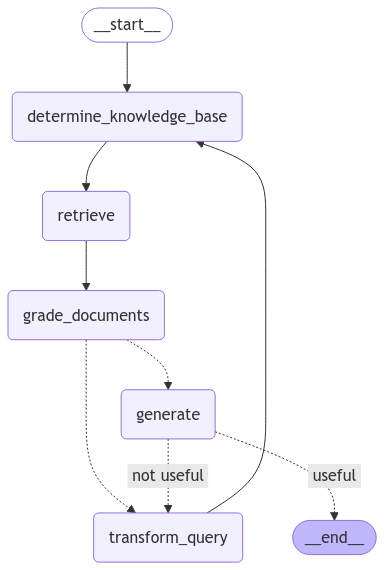

In [4]:
experiment_utils.print_graph(workflow)

In [5]:
# get document repository instance and populate vectorstore with documents
# document_repository = container.document_repository()
# experiment_utils.create_static_document(
#     embeddings_model=adaptive_rag_agent.get_embeddings_model(agent_id),
#     document_repository=document_repository,
#     file_path="tests/integration/sun_tzu_the_art_of_war.zip"
# )

In [6]:
agent_config = {
    "configurable": {
        "thread_id": agent_id,
    }
}

In [7]:
message = MessageRequest(
    message_role="human",
    message_content="What characterizes a good military leader, which examples can be borrowed from the static_document_data?",
    agent_id=agent_id
)
inputs = adaptive_rag_agent.get_input_params(message)

In [8]:
result = workflow.invoke(inputs, agent_config)

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "agent_id": "ee9b7106-4b39-473f-ae4c-d8834d5a20b3",
  "query": "What characterizes a good military leader, which examples can be borrowed from the static_document_data?",
  "preparation_system_prompt": "You are an expert at routing a user query to a knowledge_base.\nThe knowledge_base contains documents that can help replying effectively input query {query}.\nNo explanation necessary only selection.\nYou are not supposed to answer user query, you are supposed to select *exactly one* of the following items that best\nmatch the input query:\n- \"static_document_data\"\n- \"temporal_financial_data\"\n- \"backend_api_data\"\n- \"previous_conversations\"",
  "execution_system_prompt": "You are an assistant for query-answering tasks.\nUse the following pieces of retrieved context to formulate a good reply to input query.\nIf you don't know the answer, just say that you don't know.\nKeep the answer concise."
}
[chain/start] [c

2025-02-05 23:13:01,274 - httpx - INFO - HTTP Request: POST http://moon.btech.software:11434/api/chat "HTTP/1.1 200 OK"
/home/bsantanna/anaconda3/envs/dev/lib/python3.11/site-packages/langgraph/utils/runnable.py:219: ResourceWarning: unclosed <socket.socket fd=64, family=2, type=1, proto=6, laddr=('192.168.2.198', 56370), raddr=('192.168.2.199', 11434)>
  ret = context.run(self.func, input, **kwargs)


[llm/end] [chain:LangGraph > chain:determine_knowledge_base > chain:RunnableSequence > llm:ChatOllama] [6.99s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "",
        "generation_info": {
          "model": "mistral-small:24b",
          "created_at": "2025-02-05T22:13:01.408153Z",
          "done": true,
          "done_reason": "stop",
          "total_duration": 6952081500,
          "load_duration": 573845542,
          "prompt_eval_count": 199,
          "prompt_eval_duration": 3511000000,
          "eval_count": 20,
          "eval_duration": 2641000000,
          "message": {
            "role": "assistant",
            "content": "",
            "images": null,
            "tool_calls": null
          }
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],

2025-02-05 23:13:02,016 - httpx - INFO - HTTP Request: POST http://moon.btech.software:11434/api/embed "HTTP/1.1 200 OK"
/home/bsantanna/anaconda3/envs/dev/lib/python3.11/site-packages/langgraph/utils/runnable.py:219: ResourceWarning: unclosed <socket.socket fd=65, family=2, type=1, proto=6, laddr=('192.168.2.198', 56382), raddr=('192.168.2.199', 11434)>
  ret = context.run(self.func, input, **kwargs)


[chain/start] [chain:LangGraph > chain:retrieve > chain:ChannelWrite<...,retrieve>] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:retrieve > chain:ChannelWrite<...,retrieve>] s] Exiting Chain run with output:
[outputs]
[chain/end] [chain:LangGraph > chain:retrieve] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:LangGraph > chain:grade_documents] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:grade_documents > chain:RunnableSequence] Entering Chain run with input:
{
  "query": "What characterizes a good military leader, which examples can be borrowed from the static_document_data?",
  "document": "To be ignorant of any one of the following four or five principles does not befit a warlike prince.\n\nWhen a warlike prince attacks a powerful state, his generalship shows itself in preventing the concentration of the enemy’s forces. He overawes his opponents, and their allies are prevented from joining against h

2025-02-05 23:13:09,029 - httpx - INFO - HTTP Request: POST http://moon.btech.software:11434/api/chat "HTTP/1.1 200 OK"


[llm/end] [chain:LangGraph > chain:grade_documents > chain:RunnableSequence > llm:ChatOllama] [6.99s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "",
        "generation_info": {
          "model": "mistral-small:24b",
          "created_at": "2025-02-05T22:13:09.163195Z",
          "done": true,
          "done_reason": "stop",
          "total_duration": 6982206416,
          "load_duration": 32374708,
          "prompt_eval_count": 310,
          "prompt_eval_duration": 4701000000,
          "eval_count": 17,
          "eval_duration": 2241000000,
          "message": {
            "role": "assistant",
            "content": "",
            "images": null,
            "tool_calls": null
          }
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
         

2025-02-05 23:13:24,212 - httpx - INFO - HTTP Request: POST http://moon.btech.software:11434/api/chat "HTTP/1.1 200 OK"


[llm/end] [chain:LangGraph > chain:grade_documents > chain:RunnableSequence > llm:ChatOllama] [15.18s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "",
        "generation_info": {
          "model": "mistral-small:24b",
          "created_at": "2025-02-05T22:13:24.351139Z",
          "done": true,
          "done_reason": "stop",
          "total_duration": 15173146250,
          "load_duration": 9238084,
          "prompt_eval_count": 1086,
          "prompt_eval_duration": 12852000000,
          "eval_count": 17,
          "eval_duration": 2306000000,
          "message": {
            "role": "assistant",
            "content": "",
            "images": null,
            "tool_calls": null
          }
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
      

2025-02-05 23:13:28,307 - httpx - INFO - HTTP Request: POST http://moon.btech.software:11434/api/chat "HTTP/1.1 200 OK"
/home/bsantanna/anaconda3/envs/dev/lib/python3.11/site-packages/httpx/_urlparse.py:161: ResourceWarning: unclosed <socket.socket fd=65, family=2, type=1, proto=6, laddr=('192.168.2.198', 45928), raddr=('192.168.2.199', 11434)>
  if any(char.isascii() and not char.isprintable() for char in url):


[llm/end] [chain:LangGraph > chain:grade_documents > chain:RunnableSequence > llm:ChatOllama] [3.94s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "no",
        "generation_info": {
          "model": "mistral-small:24b",
          "created_at": "2025-02-05T22:13:28.301302Z",
          "done": true,
          "done_reason": "stop",
          "total_duration": 3929061708,
          "load_duration": 9577542,
          "prompt_eval_count": 464,
          "prompt_eval_duration": 3775000000,
          "eval_count": 2,
          "eval_duration": 141000000,
          "message": {
            "role": "assistant",
            "content": "no",
            "images": null,
            "tool_calls": null
          }
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
        

2025-02-05 23:13:31,767 - httpx - INFO - HTTP Request: POST http://moon.btech.software:11434/api/chat "HTTP/1.1 200 OK"


[llm/end] [chain:LangGraph > chain:generate > chain:RunnableSequence > llm:ChatOllama] [14.31s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "A good military leader should understand key strategic principles such as preventing the concentration of enemy forces and overawing opponents to deter alliances against them.\n\nAn example borrowed from the provided context is Sun Tzu's advice for a warlike prince attacking a powerful state, which includes demonstrating generalship by stopping the enemy’s forces from uniting and intimidating opponents to prevent their allies from joining against him.",
        "generation_info": {
          "model": "mistral-small:24b",
          "created_at": "2025-02-05T22:13:42.730866Z",
          "done": true,
          "done_reason": "stop",
          "total_duration": 14302654541,
          "load_duration": 30703375,
          "prompt_eval_count": 204,
          "prompt_eval_duration": 3296000000,
          "eval_count": 

2025-02-05 23:13:48,801 - httpx - INFO - HTTP Request: POST http://moon.btech.software:11434/api/chat "HTTP/1.1 200 OK"


[llm/end] [chain:LangGraph > chain:generate > chain:grade_generation_v_documents_and_question > chain:RunnableSequence > llm:ChatOllama] [6.06s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "",
        "generation_info": {
          "model": "mistral-small:24b",
          "created_at": "2025-02-05T22:13:48.936587Z",
          "done": true,
          "done_reason": "stop",
          "total_duration": 6052267042,
          "load_duration": 31522125,
          "prompt_eval_count": 242,
          "prompt_eval_duration": 3763000000,
          "eval_count": 17,
          "eval_duration": 2253000000,
          "message": {
            "role": "assistant",
            "content": "",
            "images": null,
            "tool_calls": null
          }
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
   

In [9]:
print(result['generation'])

A good military leader should understand key strategic principles such as preventing the concentration of enemy forces and overawing opponents to deter alliances against them.

An example borrowed from the provided context is Sun Tzu's advice for a warlike prince attacking a powerful state, which includes demonstrating generalship by stopping the enemy’s forces from uniting and intimidating opponents to prevent their allies from joining against him.
